In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

In [2]:
 import glob
import os 
from random import shuffle
from nlpia.loaders import get_data

def pre_process_data(filepath):
    positive_path = os.path.join(filepath,'pos')
    negative_path = os.path.join(filepath,'neg')
    pos_label = 1
    neg_label = 0
    dataset = []
    for filename in glob.glob(os.path.join(positive_path,'*.txt')):
        dataset.append((pos_label,filename))
    for filename in glob.glob(os.path.join(negative_path,'*.txt')):
        dataset.append((neg_label,filename))
    shuffle(dataset)
    return dataset
dataset = pre_process_data(r'D:\迅雷下载\nlpia-master-源代码及下载资源\dataset\7.4.1- IMDB电影评论数据集\aclImdb\train')
dataset[0:5]

C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\pugnlp\constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\pugnlp\constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\pugnlp\tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\pugnlp\util.py:80: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version.

[(0,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\neg\\6390_2.txt'),
 (1,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\pos\\1833_10.txt'),
 (0,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\neg\\731_3.txt'),
 (1,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\pos\\11781_8.txt'),
 (0,
  'D:\\迅雷下载\\nlpia-master-源代码及下载资源\\dataset\\7.4.1- IMDB电影评论数据集\\aclImdb\\train\\neg\\8140_2.txt')]

In [3]:
#加载谷歌预训练词向量
from gensim.models.keyedvectors import KeyedVectors
from nltk.tokenize import TreebankWordTokenizer
word_vector=KeyedVectors.load_word2vec_format(r'D:\迅雷下载\GoogleNews-vectors-negative300.bin.gz',binary=True)
tokenizer=TreebankWordTokenizer()

INFO:gensim.models.utils_any2vec:loading projection weights from D:\迅雷下载\GoogleNews-vectors-negative300.bin.gz
INFO:gensim.models.utils_any2vec:loaded (3000000, 300) matrix from D:\迅雷下载\GoogleNews-vectors-negative300.bin.gz


In [4]:
#划分数据集
import numpy as np

split_point=int(len(dataset)*0.8)
trainData=dataset[:split_point]
testData=dataset[split_point:]



def token_and_vectorize(filename,tokenizers):       #将句子转换为词向量
    sample_vec=[]
    with open(filename,'r',encoding='utf-8') as f:
        tokens=tokenizer.tokenize(f.read())
        for token in tokens:
            try:
                sample_vec.append(word_vector[token])
            except:
                pass
    return sample_vec


def collect_expected(dataset):       #得到标签
    expected = []
    for sample in dataset:
        expected.append(sample[0])
    return expected

def pad_trunc(data,maxlen=400):      #将每个句子的词向量长度规范到400
    zero_vector=[]
    for _ in range(len(data[0])):
        zero_vector.append(0.0)
    if len(data)>maxlen:
        temp=data[:maxlen]
    elif len(data)<maxlen:
        temp=data
        additional_elems=maxlen-len(data)
        for _ in range(additional_elems):
            temp.append(zero_vector)
    else:
        temp=data
    return temp



def data_generator(data_store,tokenizers,batchsize=32,maxlen=400,embedding_dims=300):
    X,Y=[],[]
    while True:
        for i in range(len(data_store)):
            if (i % batchsize==0 and X and Y) or (i==len(data_store)):
                X=np.reshape(X,(len(X),maxlen,embedding_dims))
                Y=np.array(Y)
                yield X,Y
                X,Y=[],[]
            x,y=data_store[i][1],data_store[i][0]
            x=pad_trunc(token_and_vectorize(x,tokenizers),maxlen=maxlen)    
            X.append(x)
            Y.append(y)

In [5]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,LSTM
import math



import math

#设置CNN参数
num_netrons = 50
maxlen = 400
batch_size = 32 
embedding_dim = 300    #词向量长度
filters = 250
kernel_size = 3
hidden_dim = 250
epochs = 2

model = Sequential()
model.add(LSTM(num_netrons,return_sequences=True,input_shape=(maxlen,embedding_dim)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

X_test=data_generator(testData,tokenizer,batchsize=batch_size,maxlen=maxlen)

trainlen = len(trainData)
testlen = len(testData)

history=model.fit(data_generator(trainData,tokenizer,batchsize=batch_size,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=3,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 400, 50)           70200     
_________________________________________________________________
dropout (Dropout)            (None, 400, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 20001     
Total params: 90,201
Trainable params: 90,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
625/625 [==============================] - 181s 290ms/step - loss: 0.4324 - accuracy: 0.8034 - val_loss: 0.3548 - val_accuracy: 0.8446
Epoch 2/3
625/625 [==============================] - 73s 116ms/step - loss: 0.3222 - accuracy: 0.8662 - v

<AxesSubplot:>

(0.0, 1.0)

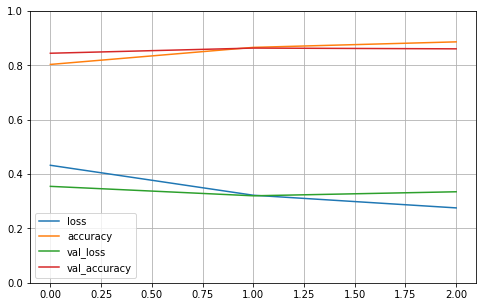

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [7]:
#保存模型

model_structure = model.to_json()
with open(r'D:\深度学习模型\nlp_9.1_lstm_model.json','w')as f:
    f.write(model_structure)
model.save_weights(r'D:\深度学习模型\nlp_9.1_lstm_weight.h5')

1847

In [8]:
#加载模型

from keras.models import model_from_json

with open(r'D:\深度学习模型\nlp_9.1_lstm_model.json','r')as f:
    json_string = f.read()
model = model_from_json(json_string)
model.load_weights(r'D:\深度学习模型\nlp_9.1_lstm_weight.h5')

In [9]:
#测试
from nltk.tokenize import TreebankWordTokenizer
import numpy as np
tokenizer = TreebankWordTokenizer()
file1 = r'D:\迅雷下载\nlpia-master-源代码及下载资源\dataset\7.4.1- IMDB电影评论数据集\aclImdb\test\pos\5_7.txt'
vec_list = token_and_vectorize(file1,tokenizer)

def reshape_400(list):
    zero_list = [0.0 for i in range(len(list[0]))]
    if len(list)>400:
        temp = list[:400]
    elif len(list)<400:
        temp = list
        for i in range(400-len(list)):
            temp.append(zero_list)
    else:
        temp = list
    return temp
test_vec_list = reshape_400(vec_list)

test_vec = np.reshape(test_vec_list,(1,400,300))

model.predict(test_vec)
model.predict_classes(test_vec)    #     pos_label = 1 ,neg_label = 0

array([[0.6674501]], dtype=float32)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1]])

# 字符级建模


In [2]:
import os
import glob
from random import shuffle
import numpy as np

def pre_process_data(filepath):
    positive_path = os.path.join(filepath,'pos')
    negative_path = os.path.join(filepath,'neg')
    pos_label = 1
    neg_label = 0
    dataset = []
    for filename in glob.glob(os.path.join(positive_path,'*.txt')):
        with open(filename,'r',encoding='utf-8') as f:
            dataset.append((pos_label,f.read()))
    for filename in glob.glob(os.path.join(negative_path,'*.txt')):
        with open(filename,'r',encoding='utf-8') as f:
            dataset.append((neg_label,f.read()))
    shuffle(dataset)
    return dataset[:10000]

def collect_expected(dataset):       #得到标签
    expected = []
    for sample in dataset:
        expected.append(sample[0])
    return np.array(expected)


def avg_len(data):
    len_ = 0
    for i in data:
        len_ += len(i[1])
    return len_/len(data)
# avg_len(dataset)    #1325.06964

def clean_data(data):
    new_data = []
    valid_char = 'abcdefghijklmnopqrsduvwxyz012345678"\'?!/,:; '
    for sample in data:
        new_sample = []
        for i in sample[1].lower():
            if i in valid_char:
                new_sample.append(i)
            else:
                new_sample.append('UNK')
        new_data.append(new_sample)
    return new_data


def char_pad_trunc(data,maxlen=1500):
    newdataset = []
    for sample in data:
        if len(sample)>maxlen:
            temp = sample[:maxlen]
        elif len(sample)<maxlen:
            add_ = maxlen-len(sample)
            for i in range(add_):
                sample.append('PAD')
            temp = sample
        else:
            temp = sample
        newdataset.append(temp)
    return newdataset

def create_dicts(data):
    chars = set()
    for sample in data:
        chars.update(set(sample))
    char_indices = dict((c,i)for c,i in enumerate(chars))
    indices_char = dict((i,c)for c,i in enumerate(chars))
    return char_indices,indices_char

def onehot_encode(dataset,char_indices,maxlen=1500):
    x = np.zeros((len(dataset),maxlen,len(char_indices.keys())))
    for i ,sentence in enumerate(dataset):
        for t,char in enumerate(sentence):
            x[i,t,indices_char[char]] = 1
    return np.array(x)

dataset = pre_process_data(r'D:\迅雷下载\nlpia-master-源代码及下载资源\dataset\7.4.1- IMDB电影评论数据集\aclImdb\test')
expected = collect_expected(dataset)
# listified_data = clean_data(dataset)

common_length_data = char_pad_trunc(clean_data(dataset),maxlen=1500)

char_indices,indices_char = create_dicts(common_length_data)
# char_indices,indices_char
common_length_data = onehot_encode(common_length_data,char_indices,1500)

split = int(len(common_length_data)*0.8)
x_train = common_length_data[:split]
y_train = expected[:split]
x_test = common_length_data[split:]
y_test = expected[split:]


In [3]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(8000, 1500, 45) (8000,)
(2000, 1500, 45) (2000,)


In [4]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,Flatten,LSTM
import math

batch_size = 50
num_neurons = 40
maxlen = 1500
model = Sequential()
model.add(LSTM(num_neurons,return_sequences=True,input_shape=(maxlen,len(char_indices.keys()))))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile('rmsprop','binary_crossentropy',metrics=['accuracy'])
model.summary()

history=model.fit(x_train,y_train,batch_size=batch_size,epochs=10,validation_data=(x_test,y_test))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1500, 40)          13760     
_________________________________________________________________
dropout (Dropout)            (None, 1500, 40)          0         
_________________________________________________________________
flatten (Flatten)            (None, 60000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 60001     
Total params: 73,761
Trainable params: 73,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
160/160 [==============================] - 8s 48ms/step - loss: 0.7381 - accuracy: 0.5121 - val_loss: 0.6928 - val_accuracy: 0.5240
Epoch 2/10
160/160 [==============================] - 7s 45ms/step - loss: 0.6343 - accuracy: 0.6529 - val_

# 生成文本_莎士比亚

In [3]:
from nltk.corpus import gutenberg

gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [16]:
#预处理莎士比亚的戏剧
text = ''
for txt in gutenberg.fileids():
    if 'shakespeare' in txt:
        text += gutenberg.raw(txt).lower()
chars = sorted(list(set(text)))
char_indices = dict((c,i) for i,c in enumerate(chars))
indices_char = dict((i,c) for i,c in enumerate(chars))
print('文章总字符数为：',len(text),'   set之后的字符数：',len(chars))

#数据细分为半冗余块
maxlen = 40
step = 3
sentence = []
next_char = []
for i in range(0,len(text)-maxlen,step):
    sentence.append(text[i:i+maxlen])
    next_char.append(text[i+maxlen])
print('sequence长度为：',len(sentence))
print('next长度为：',len(next_char))

文章总字符数为： 375542    set之后的字符数： 50
sequence长度为： 125168
next长度为： 125168


In [22]:
#将训练样本转化为独热编码
import numpy as np
x = np.zeros((len(sentence),maxlen,len(chars)),dtype=np.bool)
y = np.zeros((len(sentence),len(chars)),dtype=np.bool)
for i,sent in enumerate(sentence):
    for t,char in enumerate(sent):
        x[i,t,char_indices[char]] = 1
    y[i,char_indices[next_char[i]]] = 1
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [28]:
#组装一个LSTM模型来生成文本
from keras.models import Sequential
from keras.layers import Dense,Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

model = Sequential()
model.add(LSTM(128,input_shape=(maxlen,len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy',optimizer=optimizer)
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
activation (Activation)      (None, 50)                0         
Total params: 98,098
Trainable params: 98,098
Non-trainable params: 0
_________________________________________________________________


In [30]:
epoch = 6
batch_size = 128
model_structures = model.to_json()
with open(r'D:\深度学习模型\shakes_lstm_model.json','w') as f:
    f.write(model_structures)
for i in range(5):
    model.fit(x,y,batch_size=batch_size,epochs=epoch)
    model.save_weights(r'D:\深度学习模型\shakes_lstm_model.json')

1701

Epoch 1/6
978/978 [==============================] - 4s 4ms/step - loss: 2.0379
Epoch 2/6
978/978 [==============================] - 4s 4ms/step - loss: 1.6842
Epoch 3/6
978/978 [==============================] - 4s 4ms/step - loss: 1.5806
Epoch 4/6
978/978 [==============================] - 4s 4ms/step - loss: 1.5188
Epoch 5/6
978/978 [==============================] - 4s 4ms/step - loss: 1.4774
Epoch 6/6
978/978 [==============================] - 4s 4ms/step - loss: 1.4456


Epoch 1/6
978/978 [==============================] - 4s 4ms/step - loss: 1.4208
Epoch 2/6
978/978 [==============================] - 4s 4ms/step - loss: 1.3997
Epoch 3/6
978/978 [==============================] - 4s 4ms/step - loss: 1.3849
Epoch 4/6
978/978 [==============================] - 4s 4ms/step - loss: 1.3685
Epoch 5/6
978/978 [==============================] - 4s 4ms/step - loss: 1.3595
Epoch 6/6
978/978 [==============================] - 4s 4ms/step - loss: 1.3484


Epoch 1/6
978/978 [==============================] - 4s 4ms/step - loss: 1.3391
Epoch 2/6
978/978 [==============================] - 4s 4ms/step - loss: 1.3296
Epoch 3/6
978/978 [==============================] - 4s 4ms/step - loss: 1.3245
Epoch 4/6
978/978 [==============================] - 4s 4ms/step - loss: 1.3158
Epoch 5/6
978/978 [==============================] - 4s 4ms/step - loss: 1.3078
Epoch 6/6
978/978 [==============================] - 4s 4ms/step - loss: 1.3017


Epoch 1/6
978/978 [==============================] - 4s 4ms/step - loss: 1.2939
Epoch 2/6
978/978 [==============================] - 4s 4ms/step - loss: 1.2900
Epoch 3/6
978/978 [==============================] - 4s 4ms/step - loss: 1.2873
Epoch 4/6
978/978 [==============================] - 4s 4ms/step - loss: 1.2821
Epoch 5/6
978/978 [==============================] - 4s 4ms/step - loss: 1.2764
Epoch 6/6
978/978 [==============================] - 4s 4ms/step - loss: 1.2730


Epoch 1/6
978/978 [==============================] - 4s 4ms/step - loss: 1.2708
Epoch 2/6
978/978 [==============================] - 4s 4ms/step - loss: 1.2634
Epoch 3/6
978/978 [==============================] - 4s 4ms/step - loss: 1.2600
Epoch 4/6
978/978 [==============================] - 4s 4ms/step - loss: 1.2586
Epoch 5/6
978/978 [==============================] - 4s 4ms/step - loss: 1.2525
Epoch 6/6
978/978 [==============================] - 5s 5ms/step - loss: 1.2504


In [32]:
import random 
def sample(preds,temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)/temperature
    exp_preds = np.exp(preds)
    preds = exp_preds/np.sum(exp_preds)
    probas = np.random.multinomial(1,preds,1)    #可以模拟随机实验
    return np.argmax(probas)

import sys 
start_index = random.randint(0,len(text)-maxlen-1)
for diversity in [0.2,0.5,1.0]:
    print('---------diversity:',diversity)
    generated = ''
    sentence = text[start_index:start_index+maxlen]
    generated += sentence
    print('generating with seed:','"',generated,'"')
    sys.stdout.write(generated)
    for i in range(400):
        x = np.zeros((1,maxlen,len(chars)))
        for t,char in enumerate(sentence):
            x[0,t,char_indices[char]] = 1.
        preds = model.predict(x,verbose=0)[0]
        next_index = sample(preds,diversity)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:]+next_char
        sys.stdout.write(next_char)
        sys.stdout.flush()
        

---------diversity: 0.2
generating with seed: " ing; and when
you are ask't this questio "
ing; and when
you are ask't this question to day of the secesse,
and the spend a bong, and the call the sword

   cassi. i will not see the sword to the thing: you are the thing:
there is not the soule be a followes to thee
interpresent the stormes, and can be showes?
that the strike to the stormes, and stay the chance
to the stormes against the countrius, and then

   cassi. there's me be so much will forgles of the selfe,
and the call---------diversity: 0.5
generating with seed: " ing; and when
you are ask't this questio "
ing; and when
you are ask't this question make all,
and then caesars breath against the fire,
and his stome death, and the clouds of there.
but was to the charme, and play you booke me
with more the be commonstance of the countens,
and hee in the cause of thine, for the scele patt and by men

   ham. no my lord

   ham. i thanke you make against the mother to such a forme.

e

# 想写迭代器来训练神经网络

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,Flatten,LSTM
import math

batch_size = 50
num_neurons = 40
maxlen = 1500
model = Sequential()
model.add(LSTM(num_neurons,return_sequences=True,input_shape=(maxlen,len(char_indices.keys()))))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile('rmsprop','binary_crossentropy',metrics=['accuracy'])
model.summary()

X_test=generate_onehot(testData,char_indices,maxlen=maxlen)

trainlen = len(trainData)
testlen = len(testData)

history=model.fit(generate_onehot(trainData,char_indices,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=3,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))


In [57]:
# char_indices
# for i in common_length_data:
#     print(len(i))
trainData = common_length_data[:int(len(common_length_data)*0.8)]
testData = common_length_data[int(len(common_length_data)*0.8):]
def generate_onehot(dataset,char_indices,maxlen=1500,batch=50):
    x = np.zeros((batch,maxlen,len(char_indices.keys())))
    step = int(len(dataset)/batch)
    while True:
        for j in range(step):
            for i,sentence in enumerate(dataset[j*batch:(j+1)*batch]):
#             print(i,sentence)
                 for t,char in enumerate(sentence):
#                 print(len(sentence))
                      x[i,t,indices_char[char]] = 1
        yield x

encoded_data = generate_onehot(common_length_data,char_indices,maxlen=1500)

In [56]:
# char_indices
a = np.array(next(encoded_data))
a.shape

(50, 1500, 45)

In [60]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,Flatten,LSTM
import math

batch_size = 50
num_neurons = 40
maxlen = 1500
model = Sequential()
model.add(LSTM(num_neurons,return_sequences=True,input_shape=(maxlen,len(char_indices.keys()))))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile('rmsprop','binary_crossentropy',metrics=['accuracy'])
model.summary()

X_test=generate_onehot(testData,char_indices,maxlen=maxlen)

trainlen = len(trainData)
testlen = len(testData)

history=model.fit(generate_onehot(trainData,char_indices,maxlen=maxlen),steps_per_epoch=math.ceil(trainlen/batch_size),epochs=3,validation_data=X_test,validation_steps=math.ceil(testlen/batch_size))


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1500, 40)          13760     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1500, 40)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 60000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 60001     
Total params: 73,761
Trainable params: 73,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3


ValueError: in user code:

    C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:756 train_step
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
    C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2736 _minimize
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
    C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    C:\Users\24132\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:1270 _filter_grads
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['lstm_4/lstm_cell_4/kernel:0', 'lstm_4/lstm_cell_4/recurrent_kernel:0', 'lstm_4/lstm_cell_4/bias:0', 'dense_4/kernel:0', 'dense_4/bias:0'].
